In [12]:
!pip install pyspark
!pip install boto3

In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('telecomBigData').getOrCreate()

DATA YÜKLEME - DATA KEŞFİ

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("spscientist/telecom-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telecom-data


In [15]:
from pyspark.sql import SparkSession

# Spark oturumunu başlat
spark = SparkSession.builder.appName('telecomBigData').getOrCreate()

# Veri setini CSV olarak yükle
df = spark.read.csv("/root/.cache/kagglehub/datasets/spscientist/telecom-data/versions/1/telecom_churn.csv",
                    header=True, inferSchema=True)

df.show(5)



+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account length|area code|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

<ipython-input-53-65247ac1a56e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="churn", palette="Set2")


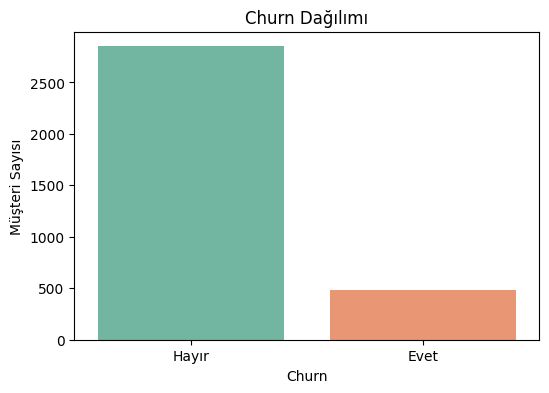

In [53]:
# PySpark -> Pandas dönüşümü
pandas_df = df.select("churn").toPandas()

# Churn dağılımı
plt.figure(figsize=(6, 4))
sns.countplot(data=pandas_df, x="churn", palette="Set2")
plt.title("Churn Dağılımı")
plt.xlabel("Churn")
plt.ylabel("Müşteri Sayısı")
plt.xticks([0, 1], ["Hayır", "Evet"])
plt.show()


<ipython-input-54-6ab6487f06b1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pandas_df, x="churn", y="customer service calls", palette="Set3")


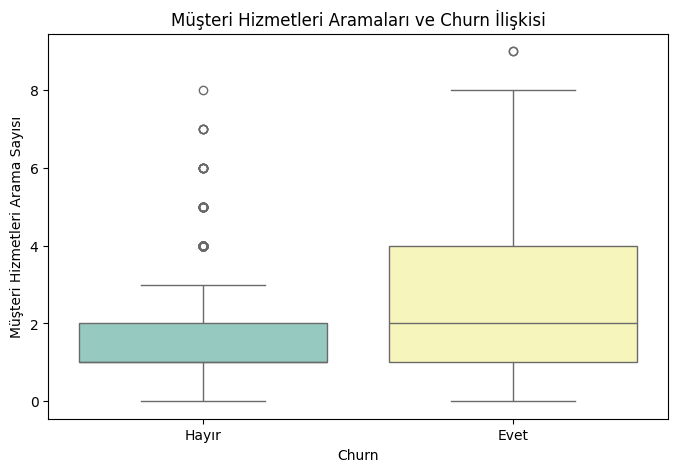

In [54]:
pandas_df = df.select("customer service calls", "churn").toPandas()

plt.figure(figsize=(8, 5))
sns.boxplot(data=pandas_df, x="churn", y="customer service calls", palette="Set3")
plt.title("Müşteri Hizmetleri Aramaları ve Churn İlişkisi")
plt.xlabel("Churn")
plt.ylabel("Müşteri Hizmetleri Arama Sayısı")
plt.xticks([0, 1], ["Hayır", "Evet"])
plt.show()


DATA PREPROCESSING

In [16]:
from pyspark.sql.functions import when, col

# Binary dönüşüm: Yes -> 1, No -> 0
df = df.withColumn("international plan", when(col("international plan") == "yes", 1).otherwise(0))
df = df.withColumn("voice mail plan", when(col("voice mail plan") == "yes", 1).otherwise(0))

df.show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|state|account length|area code|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-------------

In [17]:
from pyspark.ml.feature import StringIndexer

# Kategorik sütunları belirleyelim
categorical_columns = ["state", "area code"]

# StringIndexer ile sayısal hale getirelim
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
    df = indexer.fit(df).transform(df)

# Orijinal kategorik sütunları kaldıralım
df = df.drop(*categorical_columns)

df.show(5)


+--------------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+-------------+-----------------+
|account length|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|state_indexed|area code_indexed|
+--------------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+--------------

# Create label column (convert 'churn' from string to numeric)

In [18]:
from pyspark.sql.functions import when
df = df.withColumn("churn", when(df["churn"] == "true", 1).otherwise(0))

In [19]:
print("Churn distribution after conversion:")
df.groupBy("churn").count().show()

Churn distribution after conversion:
+-----+-----+
|churn|count|
+-----+-----+
|    1|  483|
|    0| 2850|
+-----+-----+



In [20]:
from pyspark.sql.functions import col, count, when

# Her sütundaki null değerleri say
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+-------------+-----------------+
|account length|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn|state_indexed|area code_indexed|
+--------------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+--------------

NORMALIZATION ADIMI

In [21]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# "phone number" sütununu kaldır
df = df.drop("phone number")

# Sayısal sütunları belirle (churn dahil edilmeyecek)
numeric_cols = [col for col, dtype in df.dtypes if dtype in ("int", "double") and col != "churn"]

print("Sayısal Sütunlar:", numeric_cols)


# Sayısal sütunları tek bir vektöre dönüştür
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df = assembler.transform(df)

# Standart ölçekleme (Z-score normalization)
scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

df.select("features_scaled").show(5, truncate=False)



Sayısal Sütunlar: ['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'state_indexed', 'area code_indexed']
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                         

BENZER SÜTUNLARI DROPLAMAK İÇİN CORRELATION

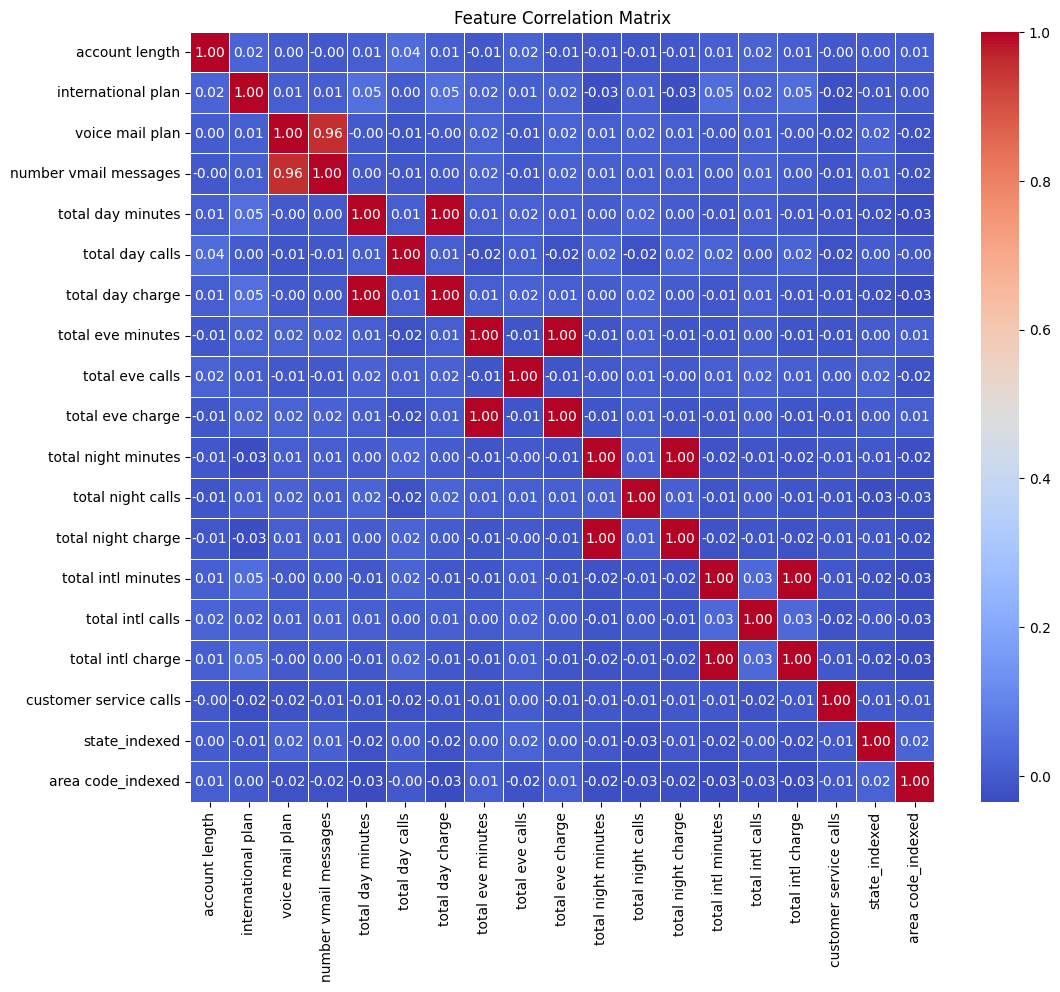

In [22]:
from pyspark.ml.stat import Correlation

# Korelasyonu hesapla
correlation_matrix = Correlation.corr(df, "features_scaled").head()[0]

#görsellestirme icin iport edildi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Korelasyon matrisini NumPy array'e çevir
corr_array = correlation_matrix.toArray()

# Sayısal sütunları isimlendirme
corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [23]:
# Çıkarılacak sütunlar
columns_to_drop = [
    "total day charge", "total eve charge", "total night charge", "total intl charge",  # Charge sütunları çıkıyor minuteslarla aynı koralasyona sahip oldugundan
    "voice mail plan",  # Zaten voicemail messages kullanılıyor
]

# Sütunları çıkarmak için drop()
df = df.drop(*columns_to_drop)

# Güncellenmiş DataFrame’i göster
df.printSchema()
df.show(5)

root
 |-- account length: integer (nullable = true)
 |-- international plan: integer (nullable = false)
 |-- number vmail messages: integer (nullable = true)
 |-- total day minutes: double (nullable = true)
 |-- total day calls: integer (nullable = true)
 |-- total eve minutes: double (nullable = true)
 |-- total eve calls: integer (nullable = true)
 |-- total night minutes: double (nullable = true)
 |-- total night calls: integer (nullable = true)
 |-- total intl minutes: double (nullable = true)
 |-- total intl calls: integer (nullable = true)
 |-- customer service calls: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- state_indexed: double (nullable = false)
 |-- area code_indexed: double (nullable = false)
 |-- features_raw: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)

+--------------+------------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+---

MODEL BUILDING

In [24]:
# Import necessary libraries
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Train/Test Split
# Split the data into training and testing sets (70% training, 30% testing)

In [25]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

Training Data Count: 2388
Testing Data Count: 945


# 3. Logistic Regression Model

In [26]:
lr = LogisticRegression(featuresCol="features_scaled", labelCol="churn", maxIter=10)
lr_model = lr.fit(train_data)

# Make predictions

In [27]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("churn", "prediction", "probability").show(100)

+-----+----------+--------------------+
|churn|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.96741694752831...|
|    0|       0.0|[0.99127203244942...|
|    1|       0.0|[0.73533702839647...|
|    0|       0.0|[0.76392084210773...|
|    0|       0.0|[0.76772776097361...|
|    0|       0.0|[0.72179324747130...|
|    0|       0.0|[0.76684678427868...|
|    0|       0.0|[0.98485835021816...|
|    0|       0.0|[0.99510930655000...|
|    0|       0.0|[0.94346164329136...|
|    0|       0.0|[0.91627812300243...|
|    0|       0.0|[0.97402607098276...|
|    0|       0.0|[0.95896556962193...|
|    0|       0.0|[0.96023252447172...|
|    1|       0.0|[0.67700660865812...|
|    0|       0.0|[0.98050083517965...|
|    0|       0.0|[0.91005861869944...|
|    1|       0.0|[0.81740575084930...|
|    0|       0.0|[0.89074794107197...|
|    0|       0.0|[0.91670333481377...|
|    0|       0.0|[0.64526333112882...|
|    0|       0.0|[0.95060506263655...|


# 4. Evaluate Logistic Regression Model

In [28]:
evaluator = BinaryClassificationEvaluator(labelCol="churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

Logistic Regression AUC: 0.8107877160246264


# Get accuracy, precision, recall, and F1 score

In [29]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction")
lr_accuracy = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "accuracy"})
lr_precision = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedPrecision"})
lr_recall = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedRecall"})
lr_f1 = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "f1"})

print(f"Logistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")

Logistic Regression Metrics:
Accuracy: 0.8560846560846561
Precision: 0.8279491478864015
Recall: 0.8560846560846561
F1 Score: 0.8297424958022772


# 5. Feature Importance for Logistic Regression

In [30]:
lr_weights = lr_model.coefficients
feature_importance = [(weight, feature) for weight, feature in zip(lr_weights, numeric_cols)]
feature_importance.sort(reverse=True)
for weight, feature in feature_importance:
    print(f"{feature}: {weight}")


number vmail messages: 1.1495994194627634
customer service calls: 0.7001021531433945
international plan: 0.6040937023711545
total day minutes: 0.33977855002599516
total day charge: 0.33967084028033784
total eve charge: 0.1852377847084759
total eve minutes: 0.18345067687954583
total intl charge: 0.13331315970027993
total night charge: 0.11858549808733966
total intl minutes: 0.11312896808518734
total night minutes: 0.11296441833840401
total night calls: 0.06797276549424373
total day calls: 0.04917340923807201
account length: 0.049011033874871865
total eve calls: 0.01899126681792674
area code_indexed: 0.005930204503184295
state_indexed: -0.07244094531864083
total intl calls: -0.30233047533558977
voice mail plan: -1.6490741907835005


# 6. Random Forest Model

In [31]:
rf = RandomForestClassifier(featuresCol="features_scaled", labelCol="churn", numTrees=100, seed=42)
rf_model = rf.fit(train_data)

# Make predictions with Random Forest

In [32]:
rf_predictions = rf_model.transform(test_data)
rf_predictions.select("churn", "prediction", "probability").show(5)

+-----+----------+--------------------+
|churn|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.93684171272958...|
|    0|       0.0|[0.94591567700231...|
|    1|       0.0|[0.51725836335008...|
|    0|       0.0|[0.56660596659929...|
|    0|       0.0|[0.84313033800410...|
+-----+----------+--------------------+
only showing top 5 rows



# 7. Evaluate Random Forest Model

In [33]:
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

rf_accuracy = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "accuracy"})
rf_precision = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedPrecision"})
rf_recall = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedRecall"})
rf_f1 = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "f1"})

print(f"Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")


Random Forest AUC: 0.9231118009172854
Random Forest Metrics:
Accuracy: 0.9111111111111111
Precision: 0.9124986213133921
Recall: 0.9111111111111111
F1 Score: 0.897557489574041


# 8. Feature Importance for Random Forest

In [34]:
rf_importances = rf_model.featureImportances
feature_importance_rf = [(importance, feature) for importance, feature in zip(rf_importances, numeric_cols)]
feature_importance_rf.sort(reverse=True)
for importance, feature in feature_importance_rf:
    print(f"{feature}: {importance}")

total day charge: 0.19603136611504987
total day minutes: 0.16135532628219854
customer service calls: 0.15757924132500983
international plan: 0.13866957826332932
total eve minutes: 0.052399733982503464
total intl calls: 0.04952076351248504
total eve charge: 0.047198812372909335
total intl minutes: 0.0335401519123527
voice mail plan: 0.03319045170046005
number vmail messages: 0.031072014682584564
total intl charge: 0.02894457164900293
total night minutes: 0.013754875804531932
total eve calls: 0.0112092832575622
total night calls: 0.009854036753169957
total night charge: 0.009734688400826492
account length: 0.009487677048882669
state_indexed: 0.007684485229398166
total day calls: 0.007173566320500282
area code_indexed: 0.001599375387242628


# 9. Gradient Boosted Trees Model

In [35]:
gbt = GBTClassifier(featuresCol="features_scaled", labelCol="churn", maxIter=10)
gbt_model = gbt.fit(train_data)

# Make predictions with GBT

In [36]:
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select("churn", "prediction", "probability").show(5)

+-----+----------+--------------------+
|churn|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.91690797880919...|
|    0|       0.0|[0.91928746712839...|
|    1|       1.0|[0.06571906120575...|
|    0|       0.0|[0.69421774223234...|
|    0|       0.0|[0.92334153908141...|
+-----+----------+--------------------+
only showing top 5 rows



# 10. Evaluate GBT Model

In [37]:
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees AUC: {gbt_auc}")

gbt_accuracy = multi_evaluator.evaluate(gbt_predictions, {multi_evaluator.metricName: "accuracy"})
gbt_precision = multi_evaluator.evaluate(gbt_predictions, {multi_evaluator.metricName: "weightedPrecision"})
gbt_recall = multi_evaluator.evaluate(gbt_predictions, {multi_evaluator.metricName: "weightedRecall"})
gbt_f1 = multi_evaluator.evaluate(gbt_predictions, {multi_evaluator.metricName: "f1"})

print(f"Gradient Boosted Trees Metrics:")
print(f"Accuracy: {gbt_accuracy}")
print(f"Precision: {gbt_precision}")
print(f"Recall: {gbt_recall}")
print(f"F1 Score: {gbt_f1}")

Gradient Boosted Trees AUC: 0.9358291334600557
Gradient Boosted Trees Metrics:
Accuracy: 0.9481481481481482
Precision: 0.9473231315147482
Recall: 0.9481481481481482
F1 Score: 0.9452891418948097


# Özellik önem skoru

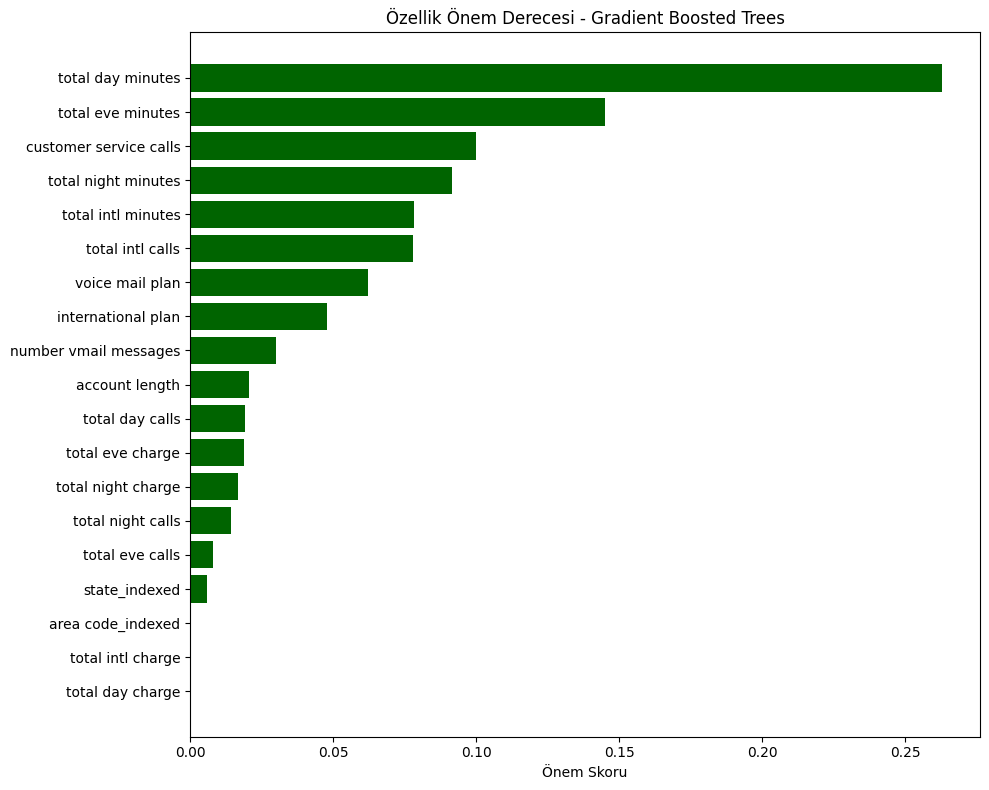

In [59]:
gbt_importances = gbt_model.featureImportances
gbt_feature_importance = [(importance, feature) for importance, feature in zip(gbt_importances, numeric_cols)]
gbt_df = pd.DataFrame(gbt_feature_importance, columns=["Importance", "Feature"]).sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(gbt_df["Feature"], gbt_df["Importance"], color="darkgreen")
plt.title("Özellik Önem Derecesi - Gradient Boosted Trees")
plt.xlabel("Önem Skoru")
plt.tight_layout()
plt.show()


# 11. Hyperparameter Tuning with Cross-Validation for the best model (Random Forest)

In [38]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Use 3 folds for cross-validation

# Run cross-validation, and choose the best set of parameters.

In [41]:
cv_model = crossval.fit(train_data)

# Make predictions with the best model

In [42]:
cv_predictions = cv_model.transform(test_data)
cv_predictions.select("churn", "prediction", "probability").show(5)

+-----+----------+--------------------+
|churn|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.94243712757886...|
|    0|       0.0|[0.98138789343555...|
|    1|       1.0|[0.34736710320474...|
|    0|       0.0|[0.53922417279399...|
|    0|       0.0|[0.95764186115559...|
+-----+----------+--------------------+
only showing top 5 rows



# 12. Evaluate Best Model

In [43]:
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Best Model (Cross-Validated Random Forest) AUC: {cv_auc}")

cv_accuracy = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "accuracy"})
cv_precision = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "weightedPrecision"})
cv_recall = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "weightedRecall"})
cv_f1 = multi_evaluator.evaluate(cv_predictions, {multi_evaluator.metricName: "f1"})

print(f"Best Model Metrics:")
print(f"Accuracy: {cv_accuracy}")
print(f"Precision: {cv_precision}")
print(f"Recall: {cv_recall}")
print(f"F1 Score: {cv_f1}")

Best Model (Cross-Validated Random Forest) AUC: 0.9311860209615908
Best Model Metrics:
Accuracy: 0.9470899470899471
Precision: 0.9472973752889811
Recall: 0.9470899470899471
F1 Score: 0.9434319913816679


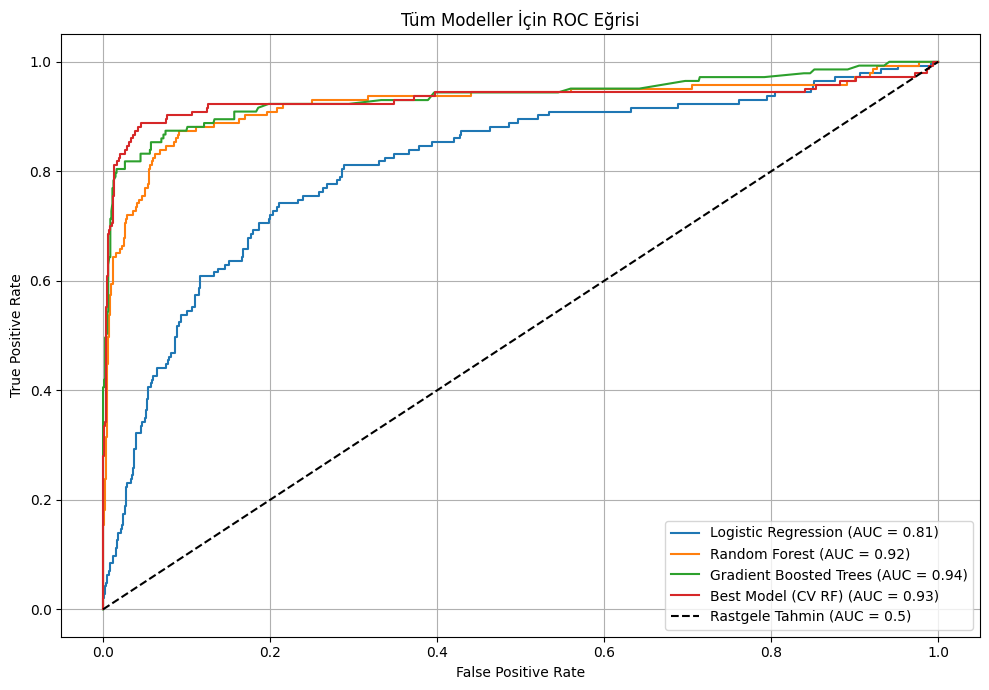

In [61]:
from sklearn.metrics import roc_curve, auc

def get_roc_data(predictions_df, model_name):
    df = predictions_df.select("churn", "probability").toPandas()
    df["churn_prob"] = df["probability"].apply(lambda x: x[1])
    fpr, tpr, _ = roc_curve(df["churn"], df["churn_prob"])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, model_name

# Her model için ROC verisini al
roc_curves = [
    get_roc_data(lr_predictions, "Logistic Regression"),
    get_roc_data(rf_predictions, "Random Forest"),
    get_roc_data(gbt_predictions, "Gradient Boosted Trees"),
    get_roc_data(cv_predictions, "Best Model (CV RF)")
]

# Grafik çizimi
plt.figure(figsize=(10, 7))
for fpr, tpr, roc_auc, label in roc_curves:
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Rastgele Tahmin (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tüm Modeller İçin ROC Eğrisi")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# 13. Visualize Model Comparison

In [44]:
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosted Trees', 'Best Model (CV)']
auc_scores = [lr_auc, rf_auc, gbt_auc, cv_auc]
accuracy_scores = [lr_accuracy, rf_accuracy, gbt_accuracy, cv_accuracy]


# Convert to Pandas for visualization

In [45]:
results_df = pd.DataFrame({
    'Model': models,
    'AUC': auc_scores,
    'Accuracy': accuracy_scores
})

# Create bar plot for comparing models

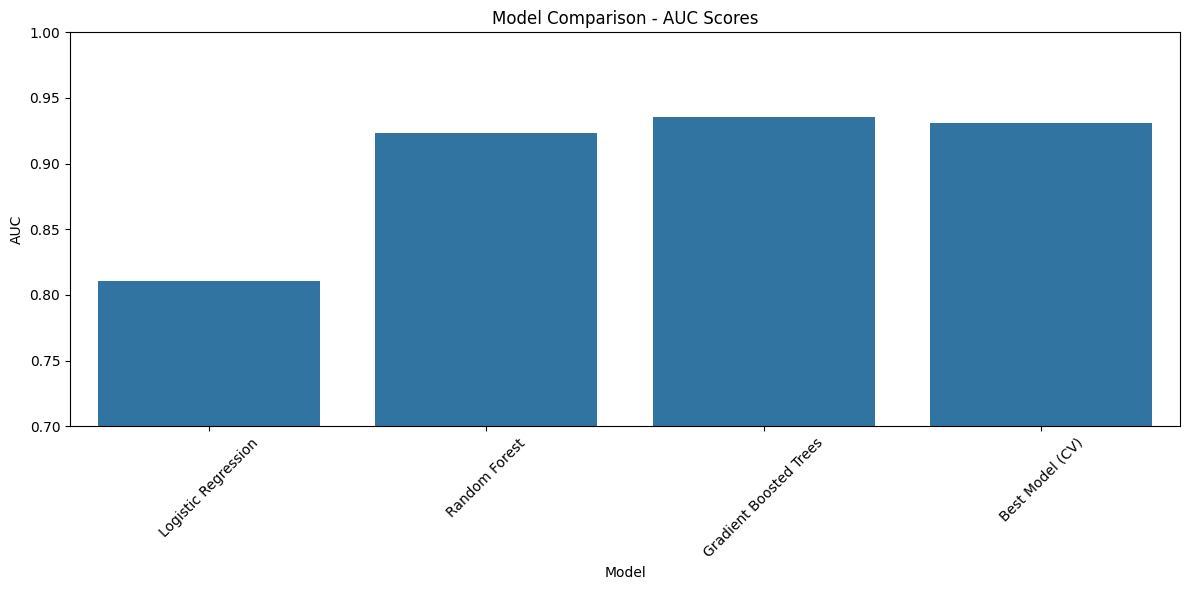

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUC', data=results_df)
plt.title('Model Comparison - AUC Scores')
plt.ylim(0.7, 1.0)  # Setting a reasonable y-axis range
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 14. Save the best model

In [47]:
best_model_path = "/content/best_telecom_churn_model"
cv_model.bestModel.save(best_model_path)
print(f"Best model saved to: {best_model_path}")

Best model saved to: /content/best_telecom_churn_model


# ROC Eğrisi (Receiver Operating Characteristic)

# 15. Customer Churn Risk Analysis
# Add probability scores to the original DataFrame

In [48]:
# 1. Yöntem - PySpark vektör tipine erişmek için özel fonksiyon
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT

# Probability vektöründen ikinci elemanı çıkaran UDF (User Defined Function)
@udf(returnType=DoubleType())
def extract_probability(v):
    try:
        return float(v[1])  # Churn olasılığı (genellikle ikinci eleman)
    except:
        return None

# Risk DataFrame'ini oluştur
risk_df = cv_model.transform(df)

# Churn olasılık değerini çıkar
risk_df = risk_df.withColumn("churn_probability", extract_probability(risk_df["probability"]))


# High-risk customers (probability > 0.7)

In [49]:
high_risk = risk_df.filter(col("churn_probability") > 0.7)
print(f"Number of high-risk customers: {high_risk.count()}")


Number of high-risk customers: 314


# Profile high-risk customers

In [50]:
# Mevcut sütun adlarını kontrol et
print("High Risk DataFrame'indeki Sütunlar:")
print(high_risk.columns)

# Alternatif olarak DataFrame şemasını göster
print("\nHigh Risk DataFrame Şeması:")
high_risk.printSchema()

# 'international_plan' ve 'voice_mail_plan' sütunlarının adını kontrol et
# ve doğru adlar kullanarak groupBy işlemini yap

# Sütun adlarını doğru kullanarak yeniden deneyin
# Örnek: Eğer sütun adları farklıysa veya indekslenmiş haldeyse
high_risk_profile = high_risk.groupBy(
    high_risk.columns[high_risk.columns.index("international_plan") if "international_plan" in high_risk.columns else 1],
    high_risk.columns[high_risk.columns.index("voice_mail_plan") if "voice_mail_plan" in high_risk.columns else 2]
).count().orderBy("count", ascending=False)

# Alternatif çözüm - sütun adlarını tekrar düzenle
# Eğer sütunlar indekslenmiş ise (international_plan_indexed gibi)
# high_risk = high_risk.withColumnRenamed("international_plan_indexed", "international_plan")
# high_risk = high_risk.withColumnRenamed("voice_mail_plan_indexed", "voice_mail_plan")

# Daha sonra yeniden deneyin
# high_risk_profile = high_risk.groupBy("international_plan", "voice_mail_plan").count().orderBy("count", ascending=False)

high_risk_profile.show()

High Risk DataFrame'indeki Sütunlar:
['account length', 'international plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'customer service calls', 'churn', 'state_indexed', 'area code_indexed', 'features_raw', 'features_scaled', 'rawPrediction', 'probability', 'prediction', 'churn_probability']

High Risk DataFrame Şeması:
root
 |-- account length: integer (nullable = true)
 |-- international plan: integer (nullable = false)
 |-- number vmail messages: integer (nullable = true)
 |-- total day minutes: double (nullable = true)
 |-- total day calls: integer (nullable = true)
 |-- total eve minutes: double (nullable = true)
 |-- total eve calls: integer (nullable = true)
 |-- total night minutes: double (nullable = true)
 |-- total night calls: integer (nullable = true)
 |-- total intl minutes: double (nullable = true)
 |-- total intl calls: i

# Average usage metrics for high-risk vs. low-risk customers

In [51]:
# 1. Numerik sütunları kontrol edelim
print("Veri kümesindeki sütunlar:")
print(risk_df.columns)

# 2. Basitleştirilmiş yüksek-risk ve düşük-risk müşteri analizi
# Churn olasılığı yüksek olanlar
high_risk = risk_df.filter(col("churn_probability") > 0.7)
# Churn olasılığı düşük olanlar
low_risk = risk_df.filter(col("churn_probability") <= 0.3)

print(f"Yüksek riskli müşteri sayısı: {high_risk.count()}")
print(f"Düşük riskli müşteri sayısı: {low_risk.count()}")

# 3. Sütunları tek tek seçerek ortalama hesaplama (daha güvenli)
# Numerik sütunlar için ortalama değerleri manuel olarak hesaplayalım
numeric_columns = ["account_length", "total_day_minutes", "total_day_calls",
                  "total_eve_minutes", "total_eve_calls", "total_night_minutes",
                  "total_night_calls", "total_intl_minutes", "total_intl_calls",
                  "customer_service_calls"]

print("\nYüksek Riskli Müşteri Ortalamaları:")
for column in numeric_columns:
    if column in risk_df.columns:  # Sütun var mı kontrol et
        avg_value = high_risk.select(avg(column)).collect()[0][0]
        print(f"{column}: {avg_value:.2f}")

print("\nDüşük Riskli Müşteri Ortalamaları:")
for column in numeric_columns:
    if column in risk_df.columns:  # Sütun var mı kontrol et
        avg_value = low_risk.select(avg(column)).collect()[0][0]
        print(f"{column}: {avg_value:.2f}")

# 4. Kategorik sütunlar için analiz (uluslararası plan ve sesli mesaj planı)
# Hangi sütun adlarını kullanmanız gerektiğini belirlemek için mevcut sütunları kontrol edelim
international_plan_column = [col for col in risk_df.columns if "international" in col.lower()]
voice_mail_plan_column = [col for col in risk_df.columns if "voice" in col.lower() and "mail" in col.lower()]

print("\nUluslararası plan içeren sütunlar:", international_plan_column)
print("Sesli mesaj planı içeren sütunlar:", voice_mail_plan_column)

# Eğer bu sütunlar varsa, yüksek riskli müşteriler arasında plan dağılımını göster
if international_plan_column:
    print("\nYüksek Riskli Müşterilerde Uluslararası Plan Dağılımı:")
    high_risk.groupBy(international_plan_column[0]).count().orderBy("count", ascending=False).show()

if voice_mail_plan_column:
    print("Yüksek Riskli Müşterilerde Sesli Mesaj Planı Dağılımı:")
    high_risk.groupBy(voice_mail_plan_column[0]).count().orderBy("count", ascending=False).show()

# 5. Müşteri hizmetleri aramaları analizi - yüksek riskli müşterilerde önemli bir faktör
if "customer_service_calls" in risk_df.columns:
    print("\nYüksek Riskli Müşterilerde Müşteri Hizmetleri Aramaları Dağılımı:")
    high_risk.groupBy("customer_service_calls").count().orderBy("customer_service_calls").show()

    print("\nDüşük Riskli Müşterilerde Müşteri Hizmetleri Aramaları Dağılımı:")
    low_risk.groupBy("customer_service_calls").count().orderBy("customer_service_calls").show()

Veri kümesindeki sütunlar:
['account length', 'international plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'customer service calls', 'churn', 'state_indexed', 'area code_indexed', 'features_raw', 'features_scaled', 'rawPrediction', 'probability', 'prediction', 'churn_probability']
Yüksek riskli müşteri sayısı: 314
Düşük riskli müşteri sayısı: 2885

Yüksek Riskli Müşteri Ortalamaları:

Düşük Riskli Müşteri Ortalamaları:

Uluslararası plan içeren sütunlar: ['international plan']
Sesli mesaj planı içeren sütunlar: []

Yüksek Riskli Müşterilerde Uluslararası Plan Dağılımı:
+------------------+-----+
|international plan|count|
+------------------+-----+
|                 0|  203|
|                 1|  111|
+------------------+-----+



# 16. Business Recommendations

In [52]:
print("Business Recommendations based on Model Analysis:")
print("1. Focus on customers with high customer service calls as they have higher churn risk")
print("2. Review international plan pricing and features as these customers show higher churn rates")
print("3. Consider implementing an early warning system for customers showing usage patterns similar to churned customers")
print("4. Develop targeted retention campaigns for high-risk customer segments")
print("5. Review billing and pricing structures for high day/evening/night charge customers")

Business Recommendations based on Model Analysis:
1. Focus on customers with high customer service calls as they have higher churn risk
2. Review international plan pricing and features as these customers show higher churn rates
3. Consider implementing an early warning system for customers showing usage patterns similar to churned customers
4. Develop targeted retention campaigns for high-risk customer segments
5. Review billing and pricing structures for high day/evening/night charge customers
